In [ ]:
# Downloading LibriSpeech Dataset
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!wget https://www.openslr.org/resources/12/train-other-500.tar.gz

In [ ]:
# Download LibriSpeech dev dataset
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz
#!wget https://www.openslr.org/resources/12/dev-other.tar.gz

In [ ]:
import tarfile

# Extract 'train-clean-100.tar.gz'
with tarfile.open('dev-clean.tar.gz', 'r:gz') as tar:
    tar.extractall('LibriSpeech/dev-clean')

"""
# Extract 'train-other-500.tar.gz'
with tarfile.open('train-other-500.tar.gz', 'r:gz') as tar:
    tar.extractall('LibriSpeech/dev-other')
"""

In [2]:
import os

# Gather audio file paths and transcriptions
dataset = []

for root, dirs, files in os.walk("LibriSpeech"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            transcript_path = os.path.join(root, file.replace(".flac", ".txt"))
            dataset.append((audio_path, transcript_path))
print(dataset[0][0])

LibriSpeech/segments/noisy/LibriSpeech/segments/noisy/652/130726/652-130726-0009_seg_0.flac


In [1]:
from pydub import AudioSegment
import numpy as np
import os
import math

def add_noise_to_audio(audio, noise_level=0.02):

    # Convert audio to numpy array (pydub uses raw audio)
    samples = np.array(audio.get_array_of_samples())
    
    # Generate random noise
    noise = np.random.normal(0, noise_level * np.max(samples), samples.shape).astype(samples.dtype)
    
    # Add noise to the audio signal
    noisy_samples = samples + noise
    noisy_samples = np.clip(noisy_samples, -32768, 32767)  # Ensure values are within int16 range
    
    # Convert numpy array back to AudioSegment
    noisy_audio = AudioSegment(
        noisy_samples.tobytes(),
        frame_rate=audio.frame_rate,
        sample_width=audio.sample_width,
        channels=audio.channels
    )
    
    return noisy_audio

def split_or_pad_audio(file_path, output_dir, segment_duration=5000):
    # Load the audio file
    audio = AudioSegment.from_file(file_path, format="flac")
    audio_length = len(audio)
    
    # Calculate the number of 5-second segments
    num_segments = math.ceil(audio_length / segment_duration)
    
    segments = []
    for i in range(num_segments):
        start = i * segment_duration
        end = start + segment_duration
        segment = audio[start:end]
        
        # If segment is less than 5 seconds, pad with silence
        if len(segment) < segment_duration:
            segment = segment + AudioSegment.silent(duration=(segment_duration - len(segment)))
        
        # Define the output file path
        segment_filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_seg_{i}.flac"
        segment_path = os.path.join(output_dir, segment_filename)
    

        noisy_seg = add_noise_to_audio(segment)
        noisy_path = segment_path.replace("clean","noisy")
        noisy_dir = os.path.dirname(noisy_path)
        os.makedirs(noisy_dir, exist_ok=True)
        noisy_seg.export(noisy_path, "flac")
        
        # Export the segment
        segment.export(segment_path, format="flac")
        segments.append(segment_path)

    
    return segments

In [ ]:
nossy_aud = add_noise_to_audio(dataset[0][0], 0.05)
audio = AudioSegment.from_file(dataset[0][0], format="flac")
print(len(audio))

# Define the output file path
output_dir = "LibriSpeech_test"  
os.makedirs(output_dir, exist_ok=True)
filename= f"{os.path.basename(dataset[0][0])}".replace(".flac",".wav")
print(filename)
path = os.path.join(output_dir, filename)

filename_noisy = f"{os.path.splitext(os.path.basename(dataset[0][0]))[0]}_noisy.wav"
path_noisy = os.path.join(output_dir, filename_noisy)
print(path_noisy)

# Export the segment
audio.export(path, format="wav")
nossy_aud.export(path_noisy, format="wav")

CUTTING AUDIOS AND ADDING NOISE

In [87]:
# Spliting Audios 5 seconds

import os
import pandas as pd

# Gather audio file paths and transcriptions
dataset = []
count = 0
max_files = 5

for root, dirs1, files in os.walk("LibriSpeech/dev-clean"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            output_dir = os.path.dirname(audio_path.replace("dev-clean", "segments/clean"))
            os.makedirs(output_dir, exist_ok=True)
            segment_list = split_or_pad_audio(audio_path,output_dir,5000)
            for segment in segment_list:
                clean_path = segment
                noisy_path = clean_path.replace("clean", "noisy")
                dataset.append((noisy_path, segment))
            count += 1
            
            if count >= max_files:
                break
    if count >= max_files:
        break

df = pd.DataFrame(dataset,columns=["noisy_path", "clean_path"])
df.to_csv("audio_dataset.csv", index=False)

In [88]:
print(dataset[1][0])
print(dataset[1][1])
naudio = AudioSegment.from_file(dataset[1][0],"flac")
caudio = AudioSegment.from_file(dataset[1][1],"flac")

naudio.export("naudio.wav","wav")
caudio.export("caudio.wav","wav")


LibriSpeech/segments/noisy/LibriSpeech/segments/noisy/652/130726/652-130726-0024_seg_1.flac
LibriSpeech/segments/clean/LibriSpeech/segments/clean/652/130726/652-130726-0024_seg_1.flac


<_io.BufferedRandom name='caudio.wav'>

In [89]:
# Transform to spectogram 
import librosa

def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes a audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    
    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase
 
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audio of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    # we extract the magnitude vectors from the 256-point STFT vectors and 
    # take the first 129-point by removing the symmetric half.

    nb_audio = numpy_audio.shape[0]
    # dim_square_spec = 256/2
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [92]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def compute_spectrogram(file_path, display=False):
    """
    Compute the spectrogram of an audio file.
    
    Parameters:
    - file_path: str, path to the .flac audio file
    - display: bool, if True, displays the spectrogram
    
    Returns:
    - S_dB: np.ndarray, decibel-scaled spectrogram
    """
    # Load audio file
    y, sr = librosa.load(file_path, sr=16000)
    
    # Compute Short-Time Fourier Transform (STFT)
    S = librosa.stft(y)
    S_phase = np.angle(S)
    
    # Convert amplitude to dB for a better visualization scale
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    
    # Display the spectrogram if needed
    if display:
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
        plt.colorbar(format="%+2.0f dB")
        plt.title("Spectrogram")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.show()
    
    return S_dB, S_phase

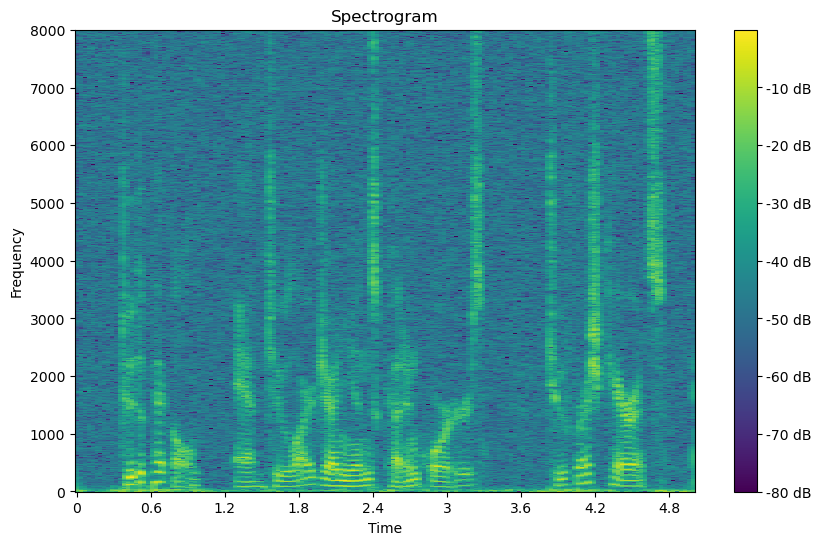

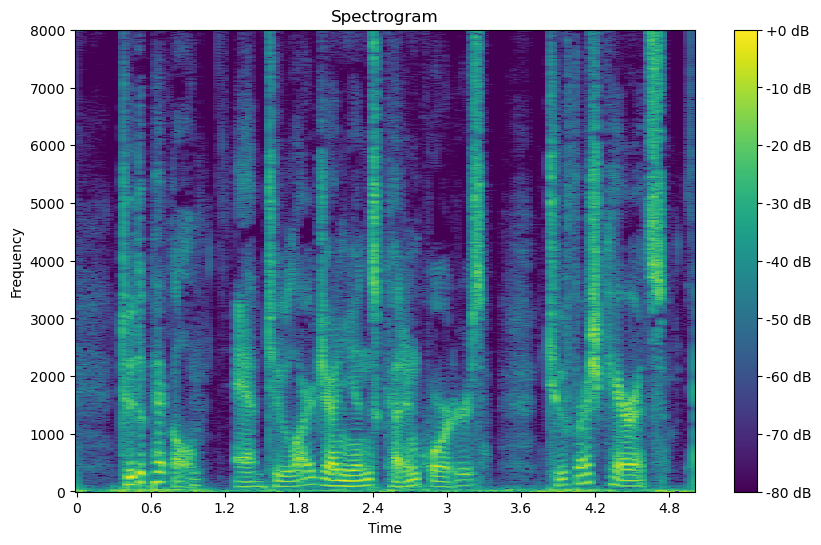

In [93]:
s_db, p1 = compute_spectrogram(dataset[0][0],True)
s2_db, p2 = compute_spectrogram(dataset[0][1],True)

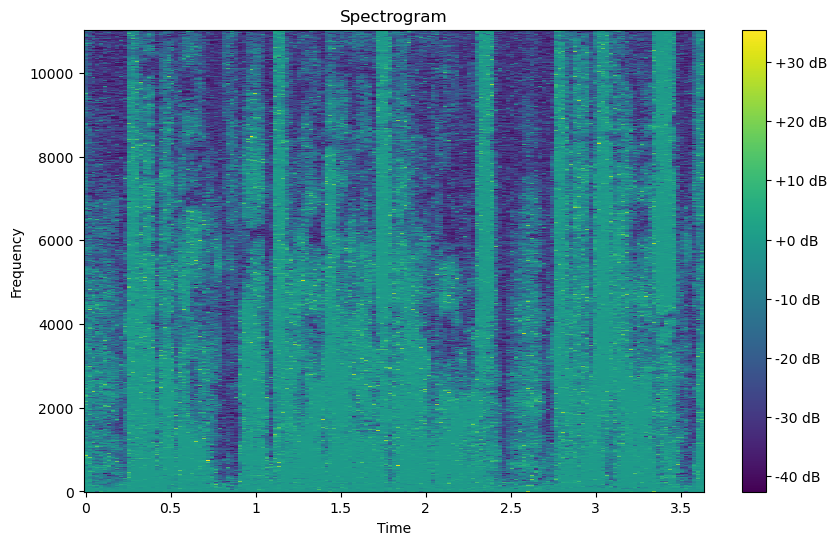

<_io.BufferedRandom name='test.wav'>

In [94]:
# Recover an audio signal
sf = s2_db-s_db
plt.figure(figsize=(10, 6))
librosa.display.specshow(sf, sr=22050, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

# Step 1: Convert dB back to amplitude
S_linear = librosa.db_to_amplitude(s_db)

# Step 2: Combine amplitude with phase to get the complex-valued spectrogram
S_complex = S_linear * np.exp(1j * np.angle(p1))

# Step 3: Perform the inverse STFT to get back the time-domain signal
y_reconstructed = librosa.istft(S_complex, hop_length=512)

y_reconstructed_int16 = np.int16(y_reconstructed / np.max(np.abs(y_reconstructed)) * 32767)
audio_segment = AudioSegment(
    y_reconstructed_int16.tobytes(), 
    frame_rate=16000, 
    sample_width=2,  # 2 bytes for 16-bit audio
    channels=1       # Mono audio
)

audio_segment.export("test.wav", format="wav")


In [37]:
# Retrieve file paths for noisy and clean audio
noisy_path = df.iloc[0]['noisy_path']
clean_path = df.iloc[0]['clean_path']
print(clean_path, noisy_path)

LibriSpeech/segments/clean/LibriSpeech/segments/clean/652/130726/652-130726-0024_seg_0.flac LibriSpeech/segments/noisy/LibriSpeech/segments/noisy/652/130726/652-130726-0024_seg_0.flac


In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, metadata_file):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.metadata = pd.read_csv(metadata_file, names=['noisy_path', 'clean_path'], skiprows=1)  

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Retrieve file paths for noisy and clean audio
        noisy_path = self.metadata.iloc[idx]['noisy_path']
        clean_path = self.metadata.iloc[idx]['clean_path']
        
        # Load audio and calculate spectrogram from clean and noisy audio
        y_noisy, sr = librosa.load(noisy_path, sr=None)
        if not isinstance(y_noisy, np.ndarray):
           y_noisy = np.array(y_noisy)
        S_noisy = librosa.stft(y_noisy, n_fft=2048, hop_length=256)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        y_clean, sr = librosa.load(clean_path, sr=None)
        if not isinstance(y_clean, np.ndarray):
            y_clean = np.array(y_clean)
        S_clean = librosa.stft(y_clean, n_fft=2048, hop_length=256)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean


80000
(1025, 313)
80000
(1025, 313)
79998
(1025, 313)
79998
(1025, 313)
80000
(1025, 313)
torch.Size([5, 1025, 313])
torch.Size([5, 1025, 157])
(1025, 313)


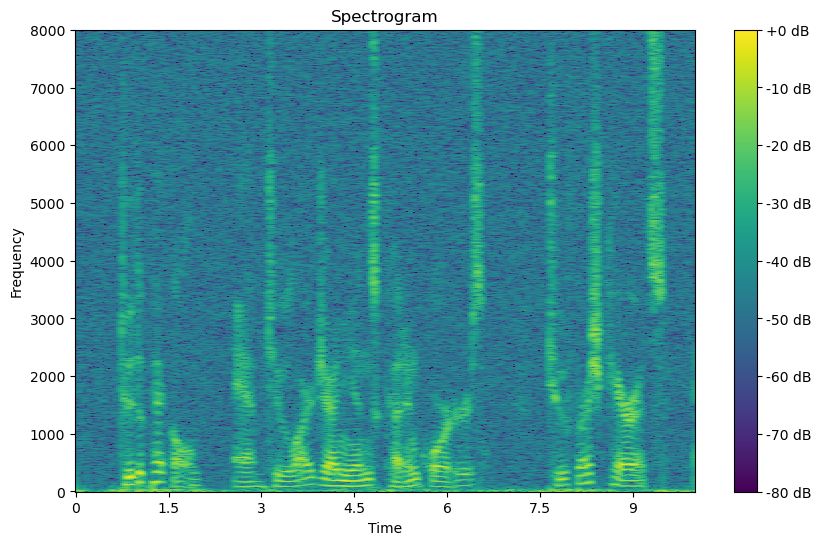

(1025, 157)


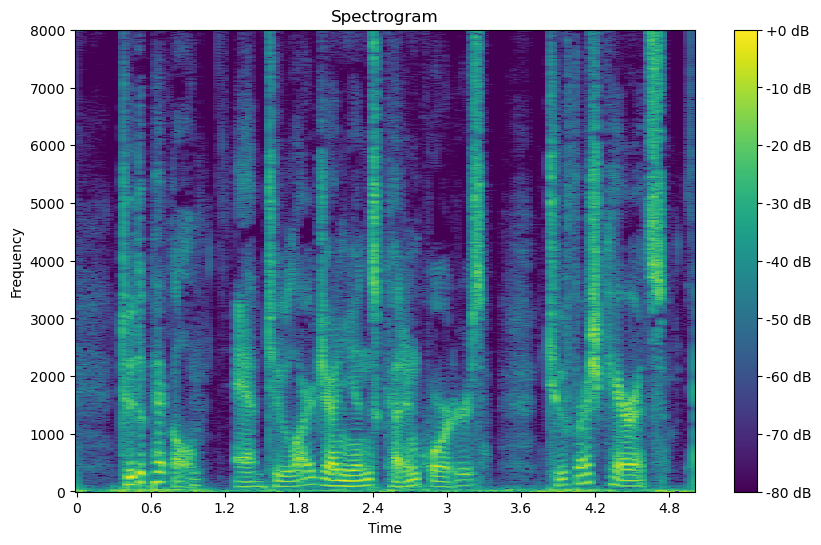

In [82]:
import librosa.display
import matplotlib.pyplot as plt

dataset = AudioDataset(metadata_file="audio_dataset.csv")
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)

for batch in dataloader:
    sp1,sp2 = batch
    print(sp1.shape)
    print(sp2.shape)
    break

print(sp1[0].numpy().squeeze().shape)
plt.figure(figsize=(10, 6))
librosa.display.specshow(sp1[0].numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

print(sp2[0].numpy().squeeze().shape)
plt.figure(figsize=(10, 6))
librosa.display.specshow(sp2[0].numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()